In [1]:
!pip install wordcloud
!pip install gensim

In [2]:
import os.path

# DATASET = 'OSCE/dor_toracica_x_infarto'
DATASET = 'clicr'


MODEL = 'bert-base-cased'
# MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'fagner/envoy'
# MODEL = 'sts-bert'
# MODEL = 'sts-biobert'

# epoch = 'best/'

# TXT_INPUT_FILE = '../datasets/' + DATASET + '/respostas_ingles.txt'
TXT_INPUT_FILE = '../datasets/' + DATASET + '/sequences.txt'

# TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/' + epoch
TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

with open(TXT_INPUT_FILE) as f:
    data_samples = f.readlines()

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

OUTPUT_PATH += 'MNT/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
    
# IMG_OUTPUT_PATH += MODEL + '/' + epoch
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

OUTPUT_PATH += 'experimentos_tese/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

# Etapa 1: Modelagem de Sentenças

In [3]:
import pandas as pd

embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
sentences_dataframe = pd.read_csv(TSV_INPUT_PATH + 'labels.tsv', sep='\t',header=None)

print('Sentenças: ')
print(sentences_dataframe, '\n\n')
print('Dimensão dos Embeddings: ', embeddings_dataframe.shape)


embeddings_numpy = embeddings_dataframe.to_numpy()
sentences_numpy = sentences_dataframe.to_numpy()
# print(sentences_numpy)
X_embeddings = embeddings_numpy[:, :-1]

sentences = []
# print(len(X_embeddings))
for x in range(len(X_embeddings)):
    sentences.append(x)

Sentenças: 
                                                       0
0      Summary This report describes a term newborn w...
1      Summary A 40 - year - old man presented with a...
2      A 40 - year - old man presented with shortness...
3      Summary Pregnancy with liver cirrhosis is a ra...
4      Description On examination , his built was nor...
...                                                  ...
10633  Description Urachal cancers are rare , account...
10634  Summary A 4.3 Mb duplication of chromosome 21 ...
10635  Summary Primary thymic extranodal marginal zon...
10636  Summary A 42 - year - old woman presented to o...
10637  Summary A woman in her 40s originally from Zim...

[10638 rows x 1 columns] 


Dimensão dos Embeddings:  (10638, 769)


### Visualização em 2d dos Embeddings de Sentença

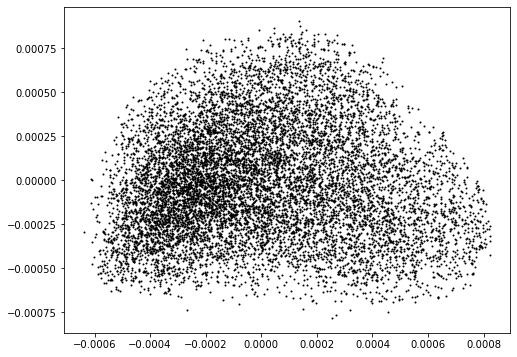

In [4]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(X_embeddings)

x = X_2d[:,0]
y = X_2d[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='black', s=1)

# for i, sentence in enumerate(sentences):
#     plt.annotate(sentence, (x[i], y[i]), fontsize=15)

plt.savefig(OUTPUT_PATH + 'sentence-embeddings')

# Etapa 2: Agrupamento

In [5]:
from sklearn.cluster import AgglomerativeClustering

clusterings = []
n_clusters = []
colors = []

# verificados
cutoff_thresholds = [55, 47, 45, 40, 35, 32, 30, 20]#bert 

#############

# cutoff_thresholds = [150, 130, 120, 110, 50, 30, 20] #sts-bert
# cutoff_thresholds = [45, 40, 30, 25, 20, 10, 9] #biobert
# cutoff_thresholds = [230, 150, 110, 50, 30, 20, 10] #envoy
# cutoff_thresholds = [200, 170, 150, 140, 130, 125, 120] #test

for threshold in cutoff_thresholds:
    clustering = AgglomerativeClustering(linkage='ward', distance_threshold=threshold, n_clusters=None)
    clustering = clustering.fit(X_embeddings)
    clusterings.append(clustering)
    
    n_clusters.append(clustering.n_clusters_)
    selected_colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering.labels_]

    colors.append(selected_colors)

### Plot a Clustering run result  

In [6]:
chosen_clustering = 0
MAX_DF = 0.95
TOP_WORDS = 50

print('Limiares: ', cutoff_thresholds)
print('Clusters: ', n_clusters)

with open(OUTPUT_PATH + '/notes.txt', "a") as file:
    print('Limiares de truncamento:: '+str(cutoff_thresholds), file=file)   
    print('Cluster resultantes: '+str(n_clusters), file=file)   
    print('chosen_clustering: '+str(chosen_clustering), file=file)   
    print('max_df: '+str(MAX_DF), file=file)
    print('Top Words: '+str(TOP_WORDS), file=file)  


Limiares:  [55, 47, 45, 40, 35, 32, 30, 20]
Clusters:  [2, 3, 4, 5, 7, 7, 9, 18]


Limiar de truncamento:  55
Cluster resultantes 2


<Figure size 432x288 with 0 Axes>

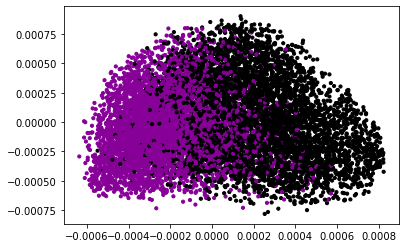

In [7]:
plt.figure()
plt.figure(figsize=(6, 4))

plt.scatter(x, y, color=colors[chosen_clustering], s=10, cmap='hsv_r')

plt.savefig(OUTPUT_PATH + 'clusters')

print('Limiar de truncamento: ', cutoff_thresholds[chosen_clustering])
print('Cluster resultantes',  n_clusters[chosen_clustering])

### 3.1 Plotando dendrograma

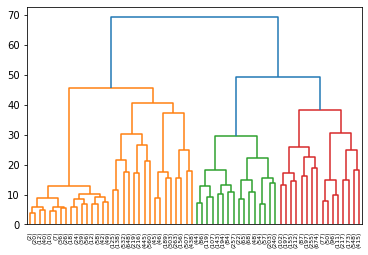

In [8]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.figure()
# plt.figure(figsize=(2, 1))

counts = np.zeros(clusterings[chosen_clustering].children_.shape[0])
n_samples = len(clusterings[chosen_clustering].labels_)
for i, merge in enumerate(clusterings[chosen_clustering].children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clusterings[chosen_clustering].children_, clusterings[chosen_clustering].distances_, counts]).astype(float)

dendrogram(linkage_matrix, truncate_mode='level', p=5)

plt.savefig(OUTPUT_PATH + 'dendrograma')


# Etapa 3: Extração de Tópicos

AgglomerativeClustering(distance_threshold=55, n_clusters=None)
Quantidade de clusters resultantes:  2
Coerência:  0.8409630719417813
Coerência por Tópico:  [0.8378127565108587, 0.844113387372704]


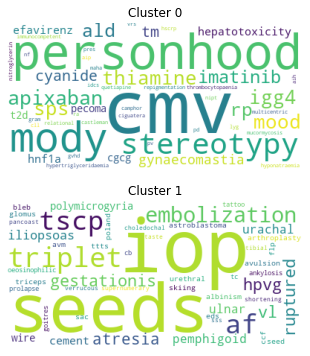

12113


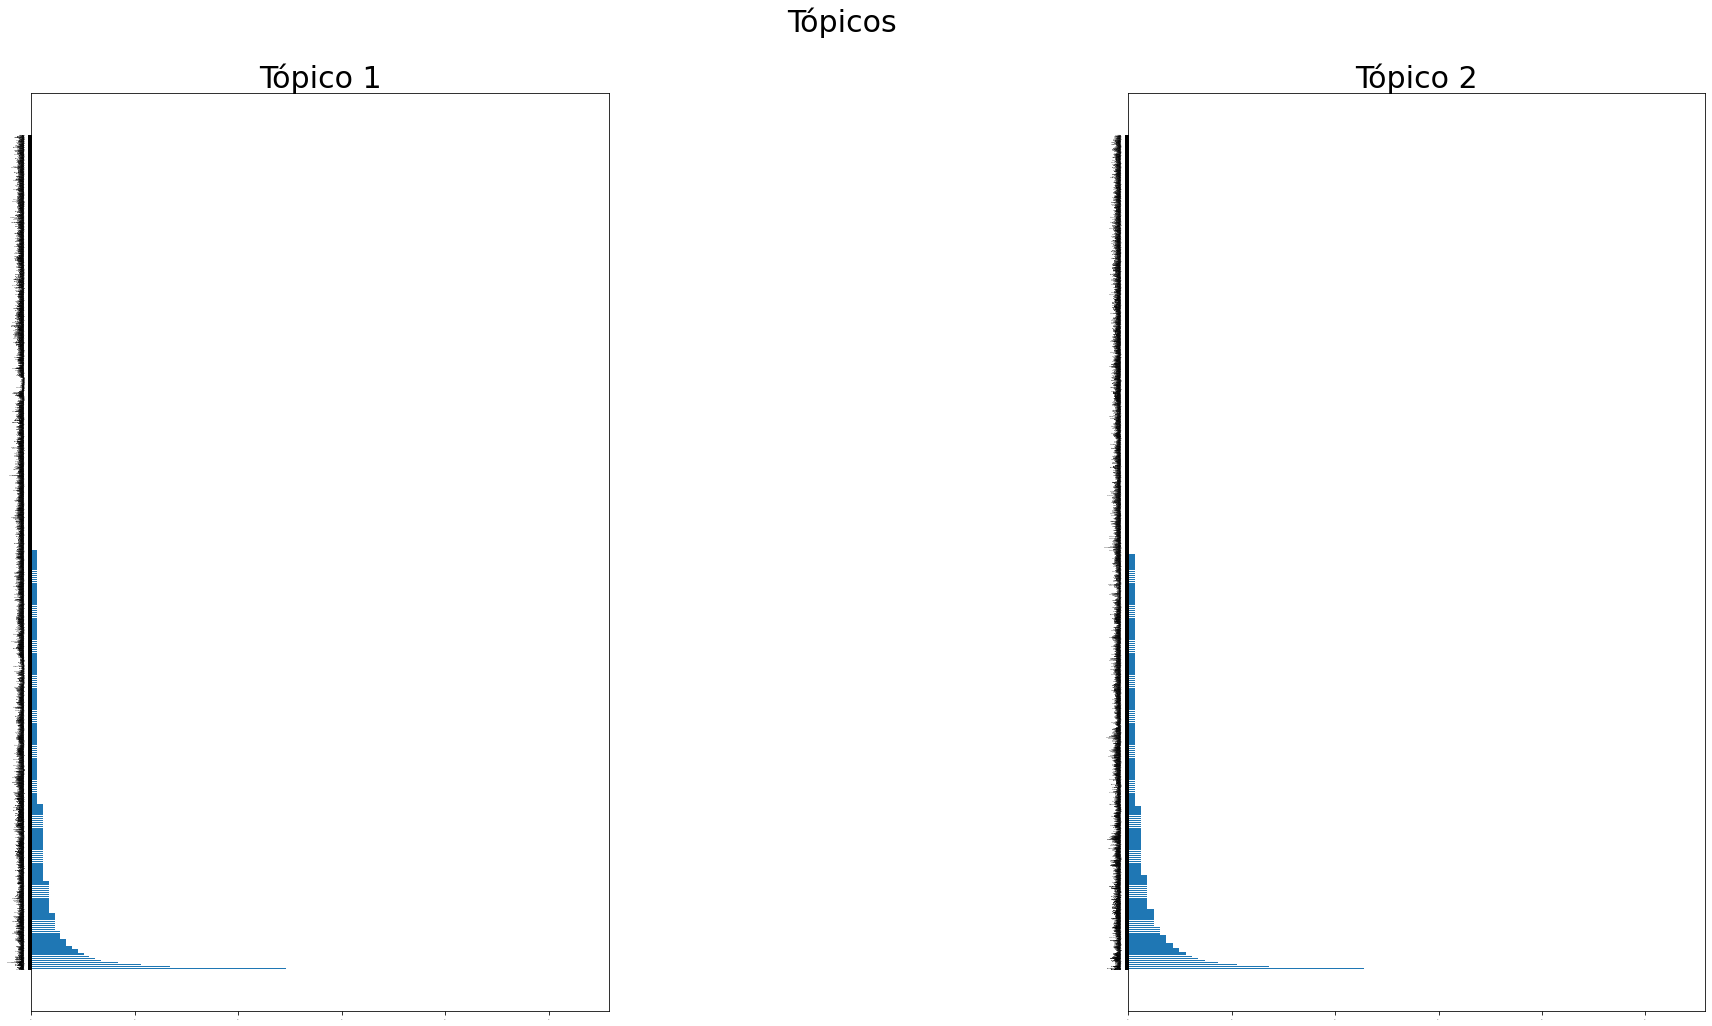

----------------------


AgglomerativeClustering(distance_threshold=47, n_clusters=None)
Quantidade de clusters resultantes:  3
Coerência:  0.8326031730614565
Coerência por Tópico:  [0.8585375168505407, 0.8923725447329375, 0.7468994576008913]


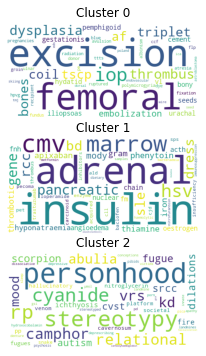

19273


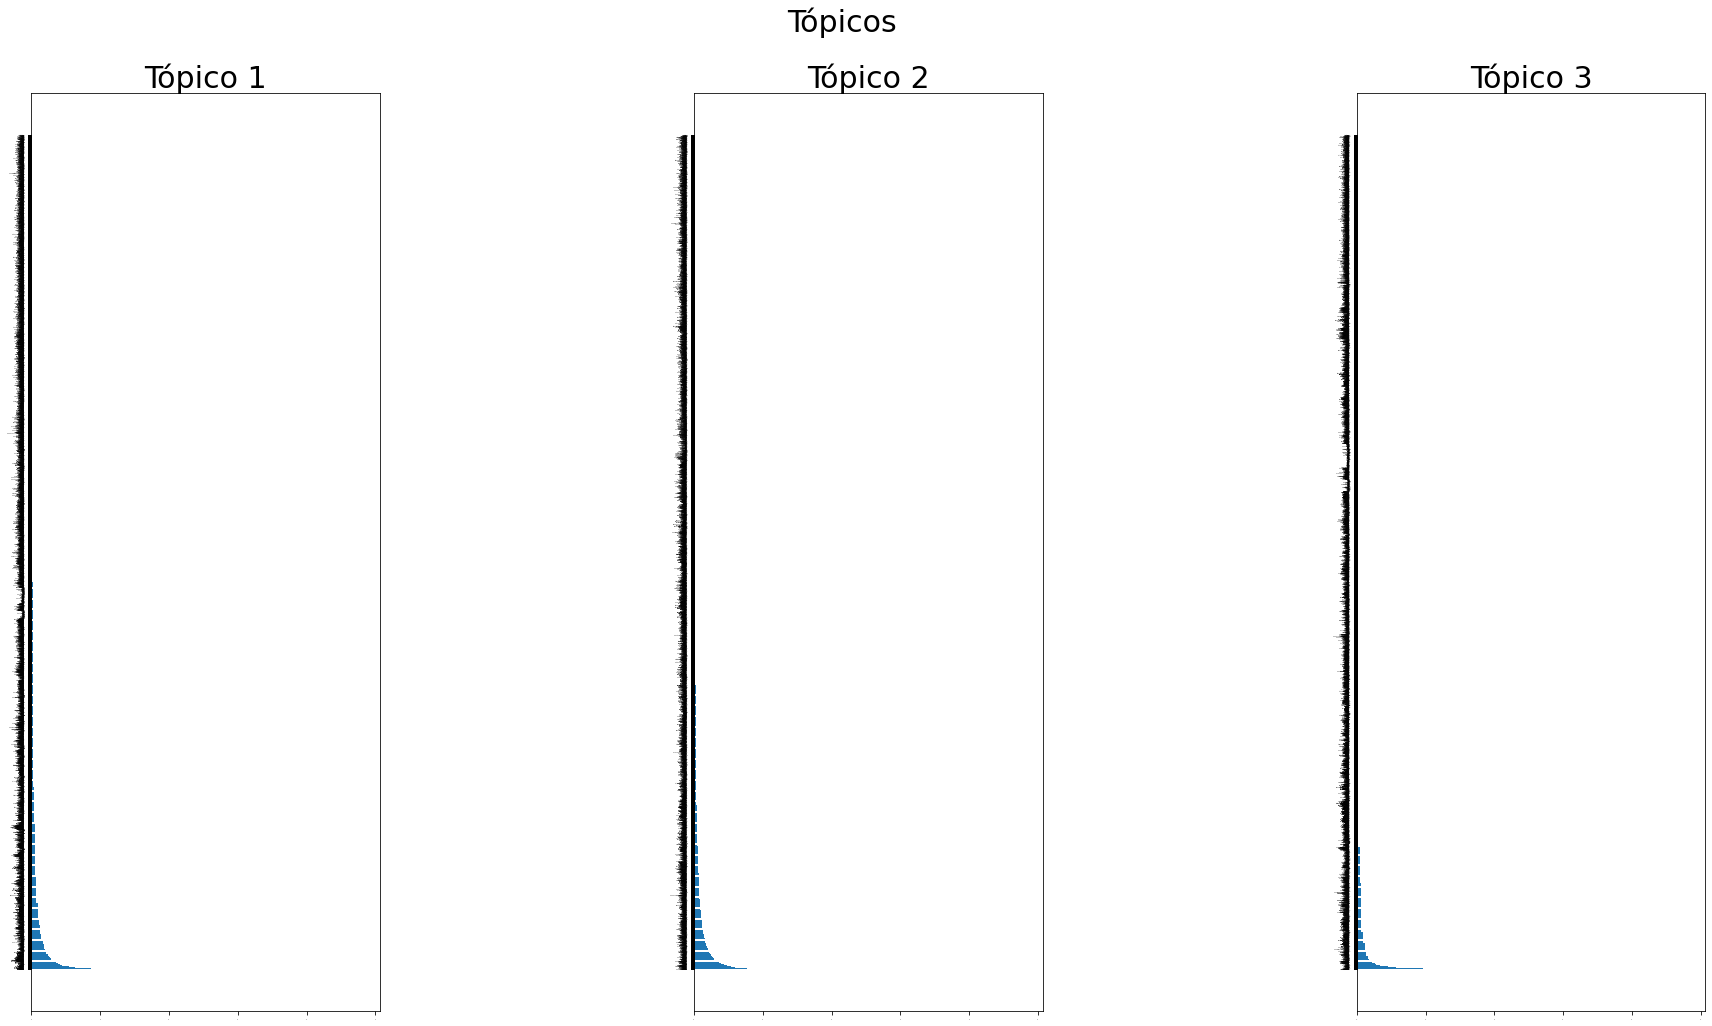

----------------------


AgglomerativeClustering(distance_threshold=45, n_clusters=None)
Quantidade de clusters resultantes:  4
Coerência:  0.8427153743276468
Coerência por Tópico:  [0.8457451566755637, 0.8901202680303381, 0.7700297187527342, 0.8649663538519512]


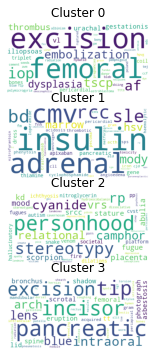

21976


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS 
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer


 
    
tf_idf_vectorizer = TfidfVectorizer(max_df=MAX_DF)
# tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)
# tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
k = 0

## Itera sobre cada resultado de uma clusterização
for n in n_clusters:
    # clusterings é uma lista de modelos de aglomeração hierárquica
    print(clusterings[k])
    print('Quantidade de clusters resultantes: ',n)

    clusters_as_documents = []
    clusters_as_documents_txt = [''] * n

    for i in range(len(sentences)):
        cluster_index = clusterings[k].labels_[i]
        sentence = sentences_numpy[i] + ' | '
        clusters_as_documents_txt[cluster_index] += sentence
    
    for document in clusters_as_documents_txt:
        clusters_as_documents.append(str(document).split('[')[1].replace('[', '').replace(']\n', '').replace('\'', ''))

    
    document_term_matrix = tf_idf_vectorizer.fit_transform(clusters_as_documents)
    terms = tf_idf_vectorizer.get_feature_names_out()
    terms_by_document = tf_idf_vectorizer.inverse_transform(document_term_matrix)
    tfidf_matrix = document_term_matrix.toarray()

    # print(document_term_matrix)
    # print(tfidf_matrix)
    
    top_terms_by_cluster = []
    top_tfidfs_by_cluster = []
    wordclouds = []

    ## Itera sobre cada documento (cluster) 
    for i in range(len(clusters_as_documents)):
        top_terms = []
        top_tfidfs = []
        
        ordered_tfidf = np.argsort(tfidf_matrix[i]) 
        top_tfidf_indexes = ordered_tfidf
        # top_tfidf_indexes = ordered_tfidf[-top_words:]
        #         top_tfidf_indexes = ordered_tfidf[-10:]
        
        for j in top_tfidf_indexes:
            top_terms.append(terms[j])
            top_tfidfs.append(tfidf_matrix[i][j])

        top_terms_by_cluster.append(top_terms)
        top_tfidfs_by_cluster.append(top_tfidfs)
        
        
        ## Criar WordCloud do Cluster
        dense = document_term_matrix[i].todense()
        lst1 = dense.tolist()
        tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

        wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
        wordclouds.append(wordcloud)

    ## Calcular Coerência dos Tópicos
    dictionary = Dictionary(terms_by_document)
    corpus = [dictionary.doc2bow(text) for text in terms_by_document]
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
    
    for i in range(len(top_terms_by_cluster)):
        top_terms_by_cluster[i] = top_terms_by_cluster[i][::-1]

    
    cm = CoherenceModel(topics=top_terms_by_cluster, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', topn=TOP_WORDS)

        
    print('Coerência: ',cm.get_coherence())
    print('Coerência por Tópico: ',cm.get_coherence_per_topic())
    #     print(top_terms_by_cluster)    
    
        
    #################
    ## Plotar Nuvens de Palavras de cada cluster
    #################
    fig, axs = plt.subplots(n, figsize=(8, 6))
    
    j=0
    for wc in wordclouds:
        axs[j].title.set_text('Cluster '+str(j))
        axs[j].imshow(wc)
        axs[j].axis("off")
        j+=1
   
    plt.savefig(OUTPUT_PATH + 'topicos_por_'+str(n)+'_clusters')
    plt.show()

    ## Plotar gráfico de barras com os termos mais relevantes de cada cluster
    fig, axes = plt.subplots(1, len(top_terms_by_cluster), figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    print(len(top_terms_by_cluster[i]))

    for i in range(len(top_terms_by_cluster)):
        ax = axes[i]
        ax.barh(top_terms_by_cluster[i], top_tfidfs_by_cluster[i], align='center')
        ax.set_title(f"Tópico {i +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=1)
        for i in "top right left".split():
            ax.spines[i].set_visible(True)
        fig.suptitle('Tópicos', fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    plt.savefig(OUTPUT_PATH + 'distributions_of_' + str(n))
    plt.show()
            # print('Limiar de distância: '+str(distance_threshold), file=file)   

    with open(OUTPUT_PATH + '/notes.txt', "a") as file:
        print('Qtdd de Tópicos: '+str(n_clusters), file=file)   
        print('Coerência total: '+str(cm.get_coherence()), file=file)  
        print('Coerência por Tópicos: '+str(cm.get_coherence_per_topic()), file=file)  
        
        print('----------------------------------------------------------------------------', file=file)  
    k+=1
    print('----------------------\n\n')
    
